In [1]:
dataset <- "ARPAFVG"
state <- "Friuli-Venezia Giulia"
match_dist <- 15000
new_dataset <- "FVG"
merging_datasets <- c("ARPAFVG", "SCIA", "ISAC")


In [2]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
Sys.setlocale("LC_ALL", "UTF-8")
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)

source("src/database/tools.R")
source("src/database/insert.R")
source("src/database/write.R")
source("src/database/startup.R")
source("src/database/plot.R")
source("src/database/query/spatial.R")
source("src/database/query/data.R")
source("src/merging/analysis.R")
source("src/merging/display.R")
source("src/merging/combining.R")
source("src/merging/tagging.R")
source("notebooks/ds_regionali/procedure/common_steps.R")

conns <- load_dbs()
state_boundaries <- query_boundary(conns$stations, state, "state")


[1] "C/UTF-8/C/C/C/C"

Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE



In [16]:
source("notebooks/ds_regionali/FVG/procedures/load_daily.R")
pre <- read.xlsx("external/correzioni/FVG_edit.xlsx") |> st_md_to_sf()
osmer <- load_osmer_meta() |> st_md_to_sf()

In [17]:
trasl <- st_join(pre, osmer, st_is_within_distance, dist = units::set_units(100, "m"), left = FALSE) |>
    st_drop_geometry() |> 
    group_by(sensor_key) |>
    slice_head() |>
    ungroup() |>
    select(sensor_key, name.y, lat.y, lon.y, elevation.y, user_code.y)

In [18]:
post <- pre |> st_drop_geometry() |> left_join(trasl)

Joining with `by = join_by(sensor_key)`


In [22]:
post |> write.xlsx("external/correzioni/FVG_edit_osmer.xlsx", rowNames = FALSE, asTable = TRUE)

In [3]:
ds_meta <- query_checkpoint_meta(dataset, "qc1", conns$data) |>
    collect()
nat_meta <- query_checkpoint_meta(c("SCIA", "ISAC"), "qc1", conns$data) |>
    collect() |>
    st_md_to_sf() |>
    st_filter(state_boundaries, .predicate = st_is_within_distance, dist = units::set_units(10, "km")) |>
    st_drop_geometry() |>
    filter(!state %in% c("Veneto"), !str_starts(series_id, "AT_"))
metadata <- bind_rows(ds_meta, nat_meta) |>
    arrange(dataset, sensor_key) |>
    mutate(key = row_number()) |>
    anti_join(tibble(sensor_key = c(31L, 3984L, 2938L, 2939L, 3911L), dataset = c("ARPAFVG", "SCIA", "ISAC", "ISAC", "SCIA")), copy = TRUE, by = c("dataset", "sensor_key")) # Monfalcone, TRIESTE and TARVISIO provide terrible data + AT stations

metadata_db <- copy_to(conns$data, metadata, "metas_tmp", overwrite = TRUE)

sensor_matches <- close_matches(metadata_db, match_dist, conns$stations)

data <- query_checkpoint_data(merging_datasets, "qc1", conns$data, hive_types = list("valid" = "BOOLEAN", "variable" = "INT")) |>
    filter(valid) |>
    inner_join(metadata_db |> select(dataset, sensor_key, key), by = c("dataset", "sensor_key")) |>
    select(!c(starts_with("qc_"), valid))

var_matches <- series_matches(data, sensor_matches, metadata_db)


In [4]:
# analysis <- series_matches_analysis(var_matches, data, metadata_db, matches_offsets = c(-1L, 0L, 1L))
# analysis |> write_xlsx_analysis(file.path("notebooks", "ds_regionali", "FVG", "raw_analysis.xlsx"))
analysis <- read_parquet(file.path("notebooks", "ds_regionali", "FVG", "raw_analysis.parquet"))


In [5]:
source("notebooks/ds_regionali/FVG/procedures/match_taggers.R")
tagged_analysis <- analysis |>
    tag_same_series() |>
    default_logic(FALSE) |>
    tag_manual()

write_xlsx_analysis(tagged_analysis, file.path("notebooks", "ds_regionali", "FVG", "tagged_analysis.xlsx"), starts_with("tag_"))


In [42]:
source("src/merging/combining.R")
path_from <- prepare_data_for_merge(conns$data)
saved_to <- merge_same_series(path_from, fs::path("db", "tmp"), new_dataset, tagged_analysis, metadata, data, 10, 0L, merging_datasets, desc(dataset))
merged_checkpoint(saved_to, metadata)


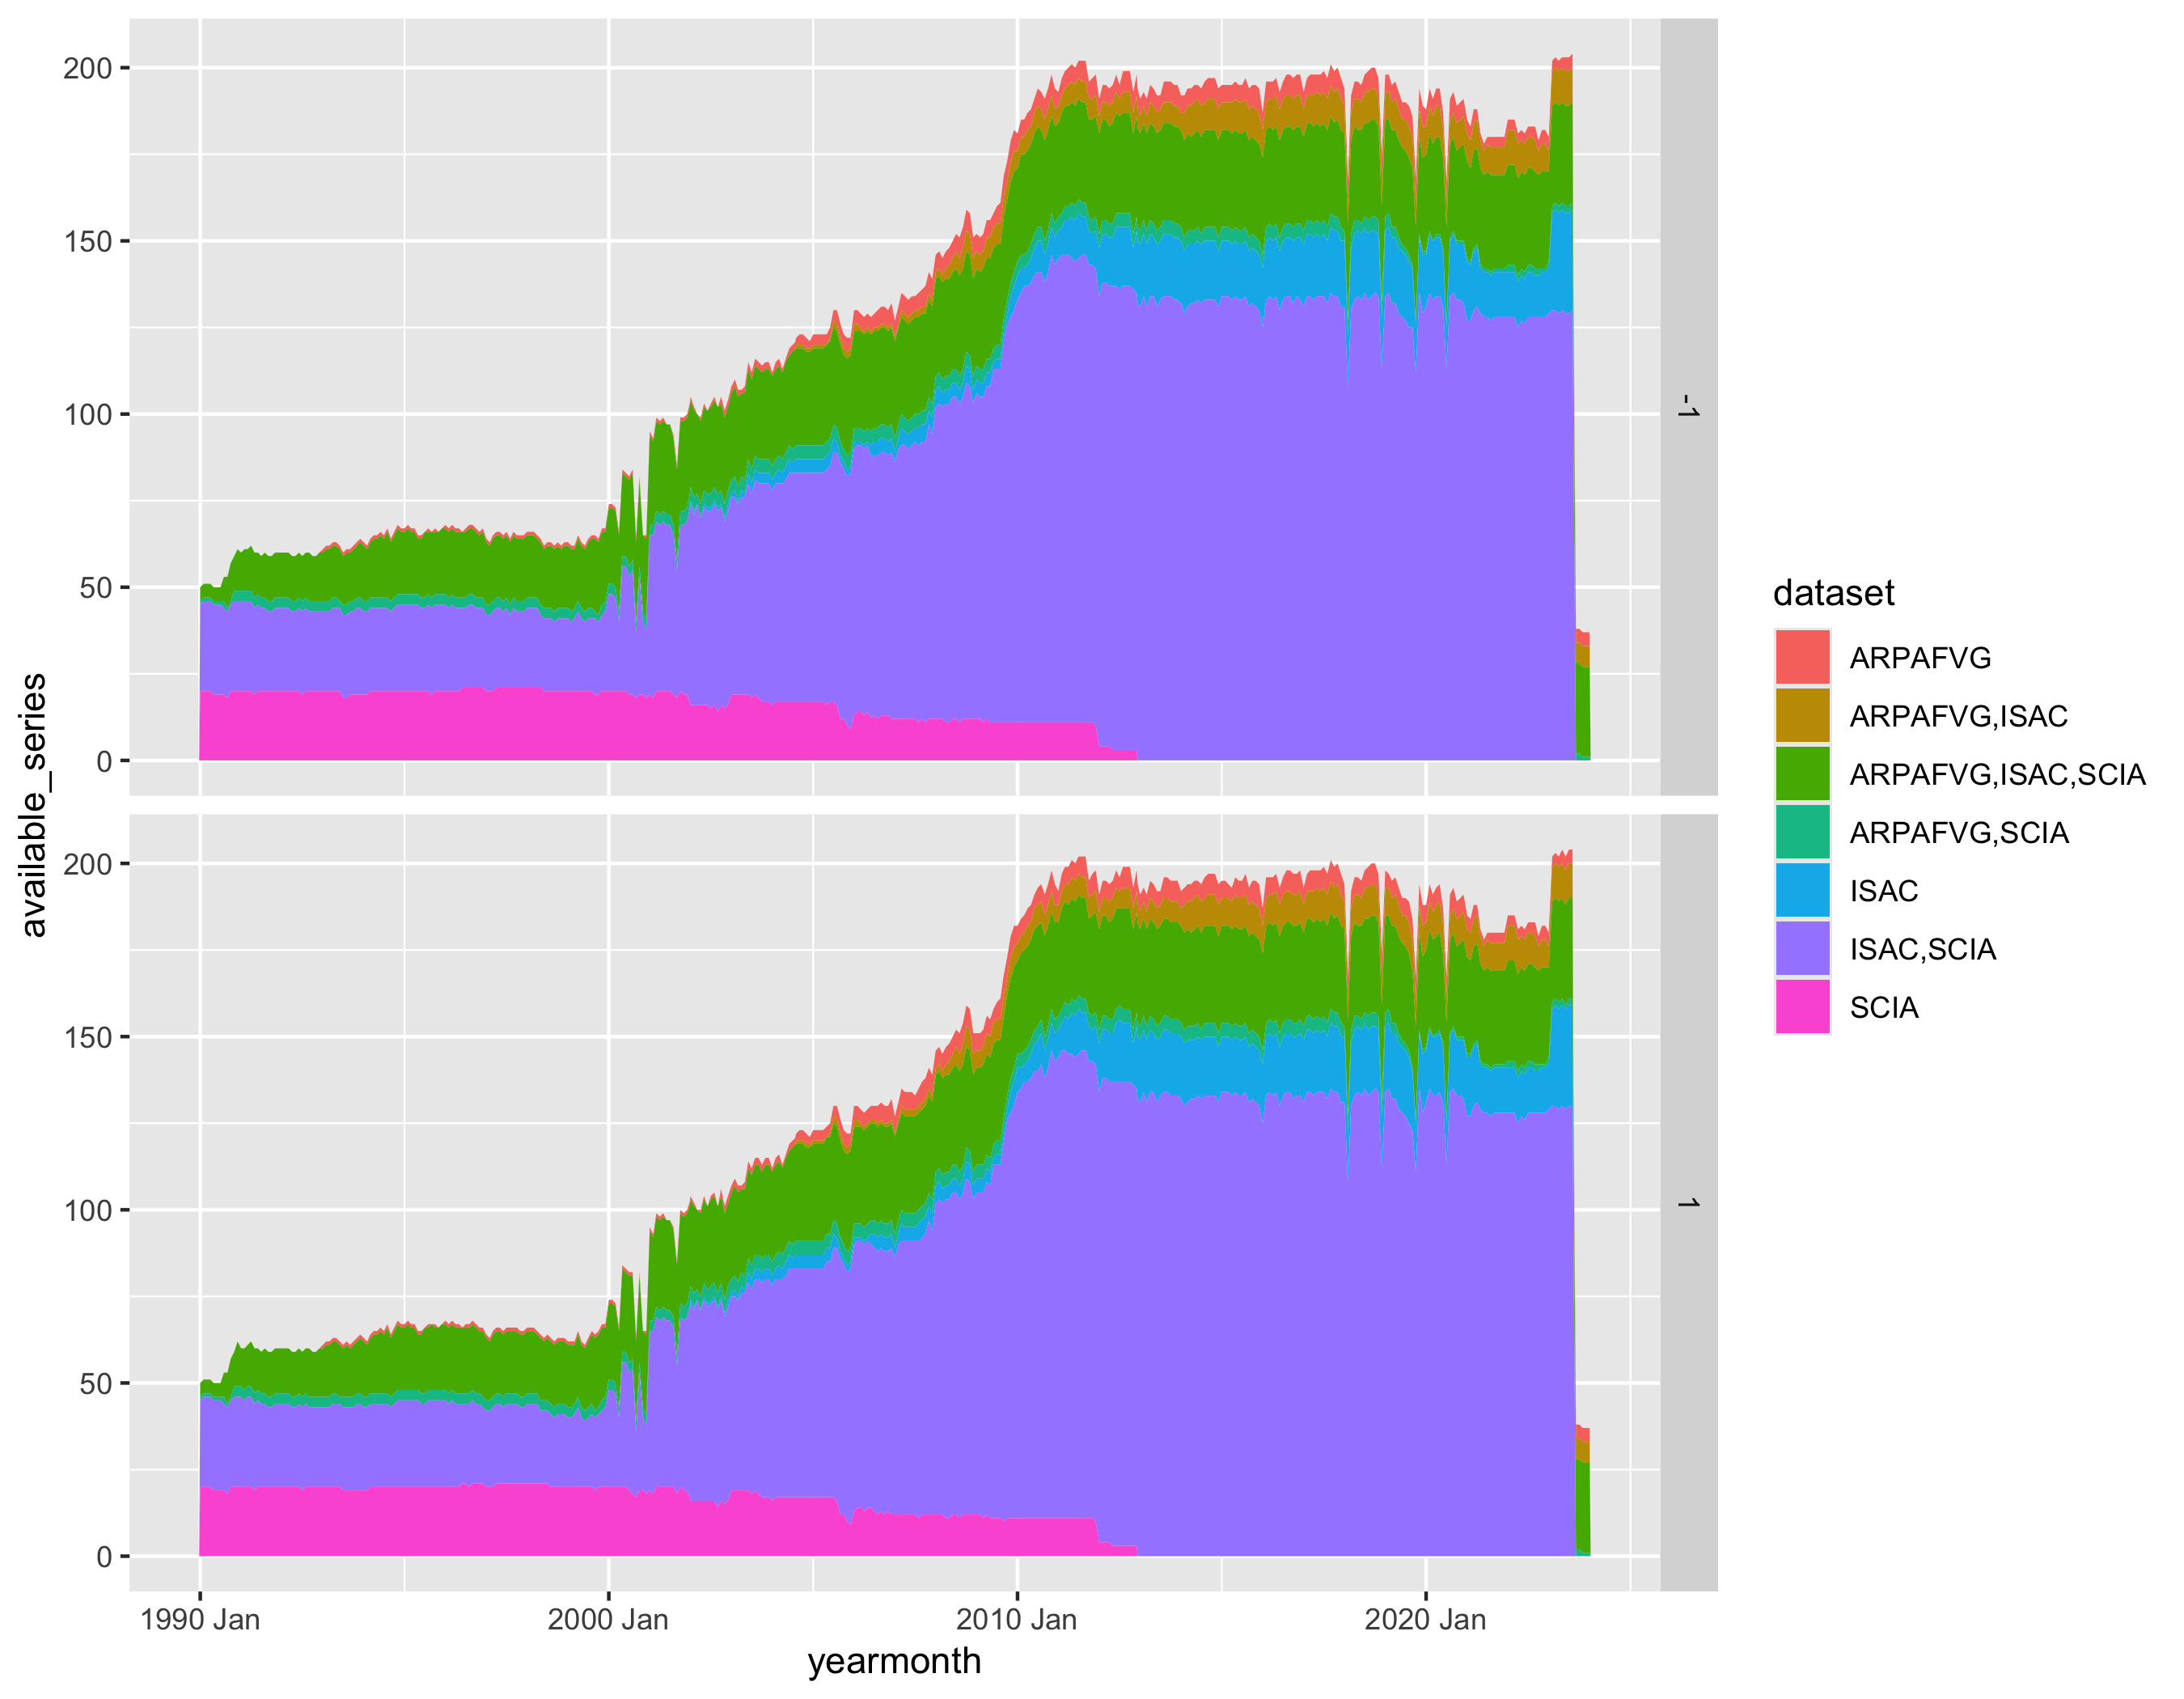

In [43]:
db <- query_checkpoint(new_dataset, "merged", conns$data, all_stations = FALSE)
mt <- db$meta |>
    select(sensor_key, from_datasets) |>
    collect() |>
    rowwise() |>
    mutate(dataset = paste0(from_datasets |> unique() |> sort(), collapse = ",")) |>
    ungroup() |>
    select(-from_datasets)
dt <- db$data |>
    select(-dataset) |>
    left_join(mt, by = "sensor_key", copy = TRUE) |>
    filter(year(date) >= 1990L)
pd <- ymonthly_availabilities(dt, stack = TRUE)
pd$plot + facet_grid(variable ~ .)


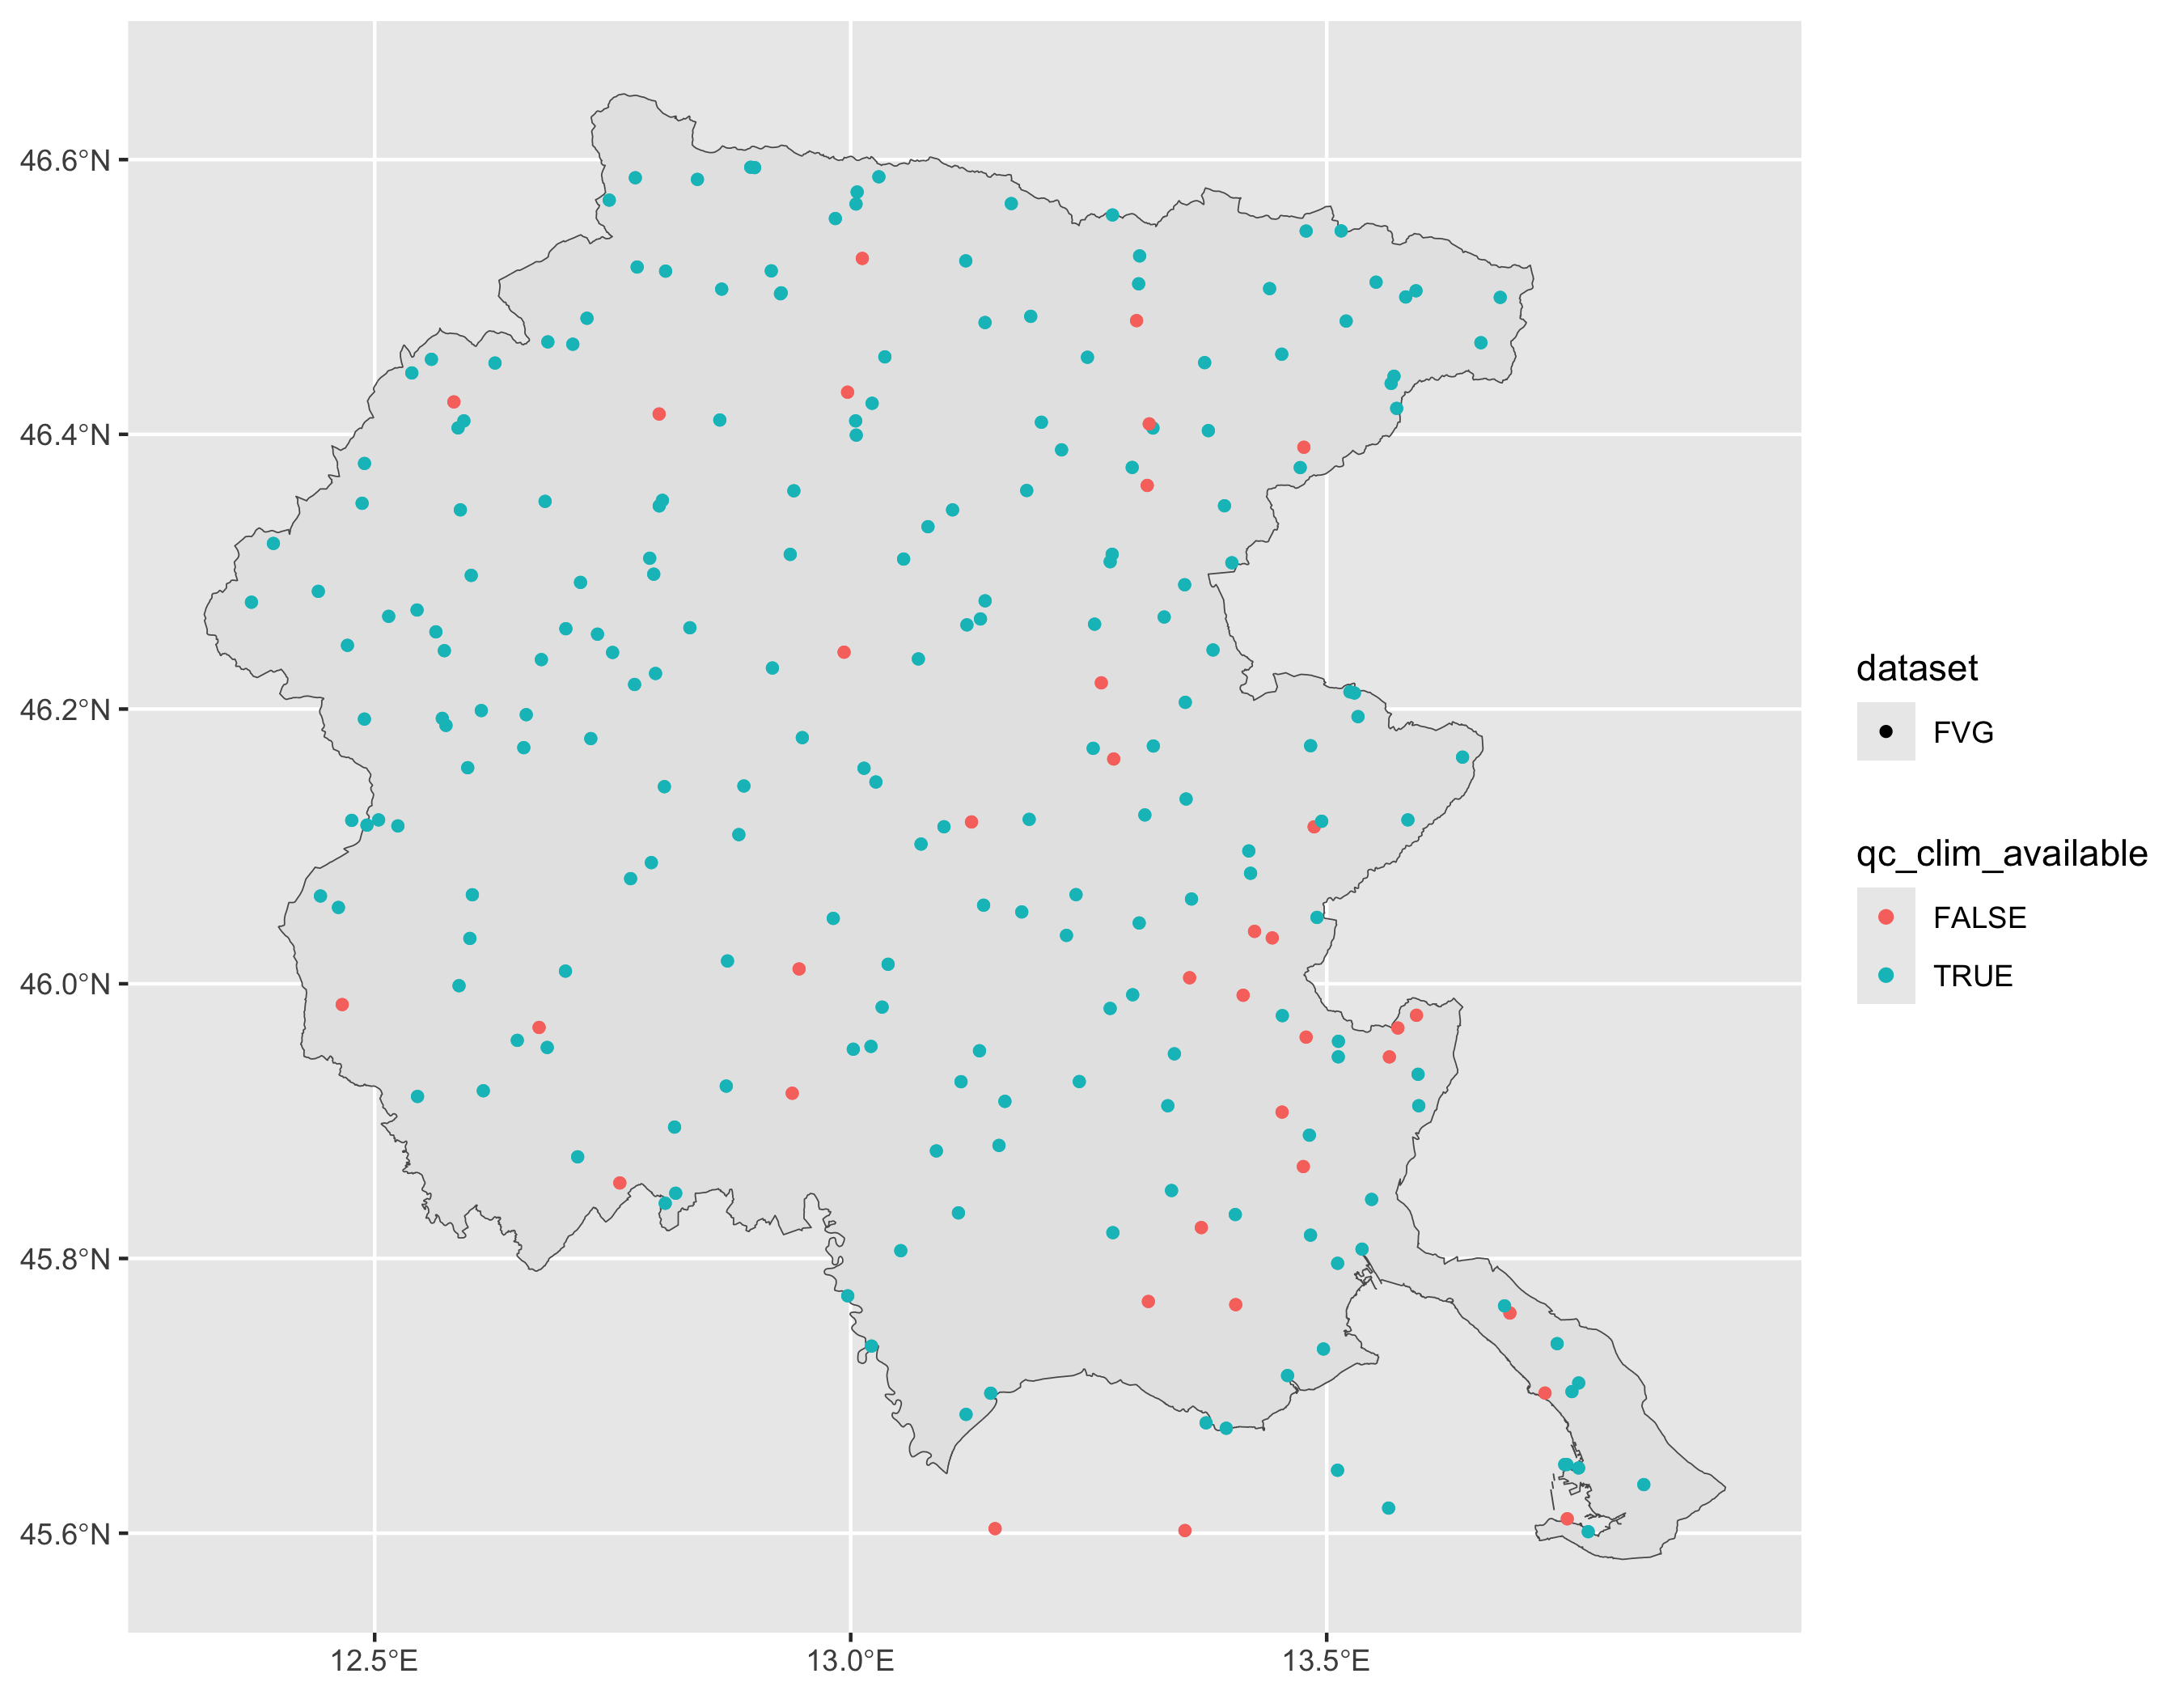

In [44]:
sp_data <- pd[[2]] |> mutate(dataset = new_dataset)
pd <- spatial_availabilities(sp_data, db$meta, state_boundaries)
pd$plot
